# PRISM_evaluation_figures

In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
from joblib import dump, load # <-- for loading sklearn models

# stats tools
from sklearn.metrics import confusion_matrix

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmaps
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu


In [2]:
import importlib
importlib.reload(du)

<module 'data_utils' from '/glade/u/home/ksha/WORKSPACE/utils/data_utils.py'>

In [3]:
%matplotlib inline

# Global settings

### File path and names

In [4]:
DATA_dir = PRISM_dir
RESULT_dir = save_dir
feature_name = 'PRISM_PCT_features_2015_2020.hdf'

# result files
PCT_PRED_name = 'OLD_results/PRISM_PRED_PCT_2015_2018.hdf'
PCT_FLAG_name = 'OLD_results/PRISM_PCT_flags_2018.hdf'
RD_name = 'OLD_results/IR_curve.npy' # reliability diagram

IR_path = RESULT_dir+'OLD_results/IR_{}.sklearn' # modeled reliability diagram (through isotonic regression)

SAVE_dir = save_dir # place for backup temporaal files

### HDF keys

In [5]:
PCT_keys = ['UNET_A', 'XNET_A', 'PCT_REGRID', 'PRISM_PCT']
# calculation keys
PCT_keys_pred = ['PCT_REGRID', 'UNET_A', 'XNET_A', 'PRISM_PCT']
# other keys
domains = ['train', 'trans']
seasons = ['djf', 'mam', 'jja', 'son']

### Time range and domain

In [6]:
N_all = 365 + 366 + 365 + 365 +1
all_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred = 366
pred_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]
# indices
ind_pred = du.dt_match(all_list, pred_list)
ind_sea = du.season_ind_sep(pred_list, key_format='{}')
ind_sea['annual'] = np.ones(N_pred).astype(bool) # add the "annual" key

# If flags and predictions have different time range
# **************************************************************** #
N_all = 366
all_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred = 366
pred_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]
# indices
ind_pred_flag = du.dt_match(all_list, pred_list)
# **************************************************************** #

# remove all-nans at the edge of the domain
pad = -15 # remove some edging grid points

# PCT histogram settings
thres = 24
pct_bins = np.linspace(thres, 180, 100)

In [7]:
with h5py.File(DATA_dir+feature_name, 'r') as hdf_io:
    lon = hdf_io['lon_4km'][...]
    lat = hdf_io['lat_4km'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
    etopo_regrid = hdf_io['etopo_regrid'][...]
    land_mask = hdf_io['land_mask'][...]

### Graphic settings

In [8]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [9]:
# precipitation cmap (from NCL)
cmap_pct = colors.LinearSegmentedColormap.from_list('temp_cmap', cmaps.prcp_1(np.arange(0, 17).tolist()))
# rain/no-rain color settings
cmap_prob = colors.LinearSegmentedColormap.from_list('temp_cmap', plt.cm.gist_stern_r(np.arange(0, 248).tolist()))
line_color1 = cmap_prob(32)
line_color2 = cmap_prob(248)

# histogram face colors
hist_colors = []
hist_colors.append('0.75')
hist_colors.append(gu.xcolor('indian red'))
hist_colors.append(gu.xcolor('light salmon'))
hist_colors.append(gu.xcolor('deep sky blue'))
hist_colors.append(gu.xcolor('royal blue'))

In [10]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0, 
            'transparent':True}

# Data and calculations

In [11]:
PCT = {}
with h5py.File(RESULT_dir+PCT_PRED_name, 'r') as hdf_io:
    for key in PCT_keys:
        temp = hdf_io[key][ind_pred, ...]
        temp[:, land_mask] = np.nan
        PCT[key] = temp

In [12]:
FLAG = {} # rain/no-rain prob.
with h5py.File(RESULT_dir+PCT_FLAG_name, 'r') as hdf_io:
    for key in PCT_keys_pred[:-1]:
        FLAG[key] = hdf_io[key][ind_pred_flag, ...]

In [13]:
reliability_diagram = np.load(RESULT_dir+RD_name, allow_pickle=True)[()]

## Rain/no-rain metrics calculation

In [14]:
# from sklearn.metrics import jaccard_score # jaccard no longer used

def ETS(TRUE, PRED):
    TN, FP, FN, TP = confusion_matrix(TRUE, PRED).ravel()
    TP_rnd = (TP+FN)*(TP+FP)/(TN+FP+FN+TP)
    return (TP-TP_rnd)/(TP+FN+FP-TP_rnd)

def freq_bias(TRUE, PRED):
    TN, FP, FN, TP = confusion_matrix(TRUE, PRED).ravel()
    return (TP+FP)/(TP+FN)

In [15]:
# rain prob to flag
FLAG_RESULT = {} # True/False arrays of rain/no-rain
thres = 0.73

for i, model in enumerate(PCT_keys_pred[:-1]):
    temp = np.zeros(PCT[model].shape).astype(bool) # initialize with all False
    for j, sea in enumerate(seasons):
        temp[ind_sea[sea], ...] = FLAG[model][ind_sea[sea], ...] >= thres # <-- warning triggered from NaN elements
    FLAG_RESULT[model] = temp

/glade/work/ksha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


In [16]:
# overlay the LR PRISM rain zones
FLAG_RESULT['XNET_A'][FLAG_RESULT['PCT_REGRID']] = True
FLAG_RESULT['UNET_A'][FLAG_RESULT['PCT_REGRID']] = True

In [17]:
TRUE_FLAG = PCT[PCT_keys_pred[-1]][...] > 0 # <-- warning triggered from NaN elements

/glade/work/ksha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [18]:
# # !!! slow 

# VERIF_RESULT = {} # verification output

# # domain separations (train v.s. trans)
# pick_flag = ~land_mask
# pick_flag_trans = np.copy(pick_flag); pick_flag_trans[:ind_trans, :] = False
# pick_flag_train = np.copy(pick_flag); pick_flag_train[ind_trans:, :] = False

# # loop over LR PRISM and UNets
# for model in PCT_keys_pred[:-1]:
#     # annual result
    
#     # data extraction
#     true_temp_train = TRUE_FLAG[:, pick_flag_train].ravel()
#     true_temp_trans = TRUE_FLAG[:, pick_flag_trans].ravel()
#     pred_temp_train = FLAG_RESULT[model][:, pick_flag_train].ravel()
#     pred_temp_trans = FLAG_RESULT[model][:, pick_flag_trans].ravel()
    
#     # verif cal
#     VERIF_RESULT['ETC_{}_annual_train'.format(model)] = ETS(true_temp_train, pred_temp_train)
#     VERIF_RESULT['ETC_{}_annual_trans'.format(model)] = ETS(true_temp_trans, pred_temp_trans)
#     VERIF_RESULT['freq_bias_{}_annual_train'.format(model)] = freq_bias(true_temp_train, pred_temp_train)
#     VERIF_RESULT['freq_bias_{}_annual_trans'.format(model)] = freq_bias(true_temp_trans, pred_temp_trans)

#     # separate by seasons
#     for sea in seasons:
        
#         # data extraction
#         true_temp_train = TRUE_FLAG[:, pick_flag_train][ind_sea[sea], :].ravel()
#         pred_temp_train = FLAG_RESULT[model][:, pick_flag_train][ind_sea[sea], :].ravel()
#         true_temp_trans = TRUE_FLAG[:, pick_flag_trans][ind_sea[sea], :].ravel()
#         pred_temp_trans = FLAG_RESULT[model][:, pick_flag_trans][ind_sea[sea], :].ravel()
        
#         # verif cal
#         VERIF_RESULT['ETC_{}_{}_train'.format(model, sea)] = ETS(true_temp_train, pred_temp_train)
#         VERIF_RESULT['ETC_{}_{}_trans'.format(model, sea)] = ETS(true_temp_trans, pred_temp_trans)
#         VERIF_RESULT['freq_bias_{}_{}_train'.format(model, sea)] = freq_bias(true_temp_train, pred_temp_train)
#         VERIF_RESULT['freq_bias_{}_{}_trans'.format(model, sea)] = freq_bias(true_temp_trans, pred_temp_trans)

In [19]:
# # ----- save verif to cache ----- #
# np.save(SAVE_dir+'PCT_RAIN_VERIF.npy', VERIF_RESULT)

In [20]:
# ----- load verif from cache ----- #
VERIF_RESULT = np.load(SAVE_dir+'PCT_RAIN_VERIF.npy', allow_pickle=True)[()]

## Applying fiags and inv-log-transformation to the raw output

In [21]:
FLAG_RESULT[PCT_keys_pred[-1]] = TRUE_FLAG

In [22]:
PCT_final = {} # "PCT" combines with "FLAG"
for model in PCT_keys:
    temp_val = np.copy(PCT[model][...]) # copy for being save
    temp_flag = FLAG_RESULT[model][...]
    temp_val[np.logical_not(temp_flag)] = 0.0 # correct no-rain to zero
    temp_val[:, land_mask] = np.nan
    PCT_final[model] = du.inv_log_trans(temp_val)

## Histogram analysis

In [23]:
# HIST = {}
# pick_flag = ~land_mask # no train/trans separation

# for i, sea in enumerate(seasons + ['annual']):
#     for j, model in enumerate(PCT_keys_pred):
#         temp_true = PCT_final[model][ind_sea[sea], ...][:, pick_flag].ravel()
#         if model == PCT_keys_pred[0]:
#             temp_true = 0.9*temp_true
#         temp_true = temp_true[temp_true>thres]
#         temp_hist, _ = np.histogram(temp_true, pct_bins)
#         HIST['{}_{}'.format(model, sea)] = temp_hist
#         HIST['{}_{}_param'.format(model, sea)] = [np.std(temp_true), np.percentile(temp_true, 99)]

In [24]:
# # ----- save verif to cache ----- #
# np.save(SAVE_dir+'PCT_PRISM_HIST.npy', HIST)

In [25]:
# ----- load verif from cache ----- #
HIST = np.load(SAVE_dir+'PCT_PRISM_HIST.npy', allow_pickle=True)[()]

## MAE calculations

In [26]:
# MAE_PCT = {}
# for key in PCT_keys_pred[:-1]:
#     # grid-point-wise MAE
#     temp_pred = np.copy(PCT_final[key])
#     temp_pred[~TRUE_FLAG] = np.nan # ignore no-rain grid points
    
#     temp_true = np.copy(PCT_final[PCT_keys_pred[-1]])
#     temp_true[~TRUE_FLAG] = np.nan # ignore no-rain grid points
    
#     MAE_PCT['{}_grid'.format(key)] = du.MAE_spatial(temp_pred, temp_true)
#     # domain averaged MAE
#     MAE_PCT['{}_trans'.format(key)] = du.MAE_temporal(temp_pred[:, ind_trans:pad, :], temp_true[:, ind_trans:pad, :])
#     MAE_PCT['{}_train'.format(key)] = du.MAE_temporal(temp_pred[:, :ind_trans, :], temp_true[:, :ind_trans, :])

In [27]:
# # ----- save MAEs to cache ----- #
# np.save(SAVE_dir+'PRISM_PCT_2019_MAE.npy', MAE_PCT)

In [28]:
# ----- load MAEs from cache ----- #
MAE_PCT = np.load(SAVE_dir+'PRISM_PCT_2019_MAE.npy', allow_pickle=True)[()]

In [29]:
MAE_PCT_season = {}

for key in PCT_keys_pred[:-1]:
    for sea in seasons + ['annual']:
        for dom in domains:
            MAE_PCT_season['{}_{}_{}'.format(key, dom, sea)] = np.mean(MAE_PCT['{}_{}'.format(key, dom)][ind_sea[sea]])

# Figures

## Rain/no-rain classification evaluation plot (replaced by a table)

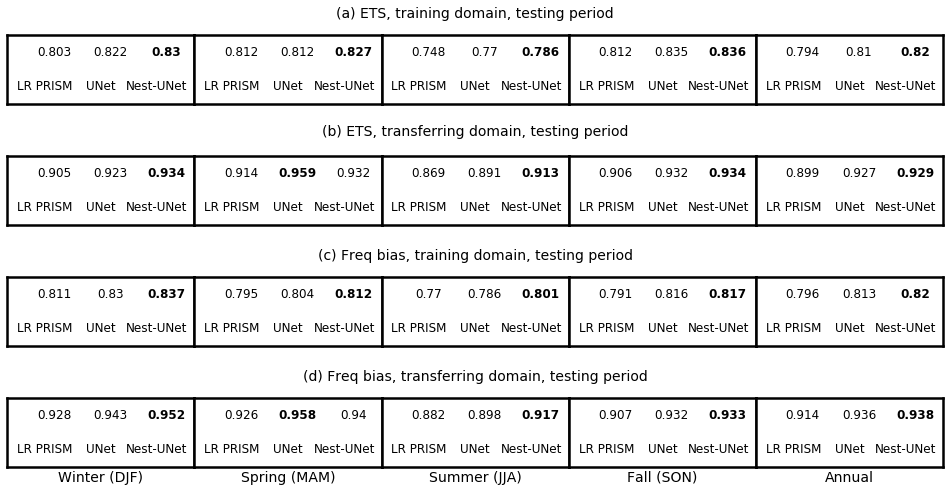

In [28]:
times = seasons + ['annual']
metrics = ['ETC', 'freq_bias']
xlabels = ['Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Fall (SON)', 'Annual']
model_name_plot = ['LR PRISM', 'UNet', 'Nest-UNet']

fig, AX = plt.subplots(4, 5, figsize=(13, 6))
plt.subplots_adjust(0, 0, 1, 1, hspace=0.75, wspace=0)

for i2, metric in enumerate(metrics):
    for i1, domain in enumerate(domains):
        i = i1*2+i2
        for j, sea in enumerate(times):
            ax = AX[i][j]
            ax = gu.ax_decorate_box(ax)
            ax.grid(False)
            temp_val = []
            for k, model in enumerate(PCT_keys_pred[:-1]):
                temp_val.append(np.array([VERIF_RESULT['{}_{}_{}_{}'.format(metric, model, sea, domain)]])[0])
                FW = ['normal']*3
                FW[np.argmax(temp_val)] = 'bold'
            for k, model in enumerate(PCT_keys_pred[:-1]): 
                ax.text(0.25+k*0.3, 0.75, str(np.round(temp_val[k], 3)), va='center', ha='center', fontweight=FW[k], fontsize=12)
                ax.text(0.20+k*0.3, 0.25, model_name_plot[k], va='center', ha='center', fontsize=12)

for i in range(5):
    AX[-1][i].set_xlabel(xlabels[i], fontsize=14)

AX[0][2].text(0.5, 1.4, '(a) ETS, training domain, testing period', 
              ha='center', va='top', fontsize=14, transform=AX[0][2].transAxes);
AX[1][2].text(0.5, 1.45, '(b) ETS, transferring domain, testing period', 
              ha='center', va='top', fontsize=14, transform=AX[1][2].transAxes);
AX[2][2].text(0.5, 1.4, '(c) Freq bias, training domain, testing period', 
              ha='center', va='top', fontsize=14, transform=AX[2][2].transAxes);
AX[3][2].text(0.5, 1.4, '(d) Freq bias, transferring domain, testing period', 
              ha='center', va='top', fontsize=14, transform=AX[3][2].transAxes);

## Rain/no-rain classification example plot

/glade/work/ksha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator IsotonicRegression from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


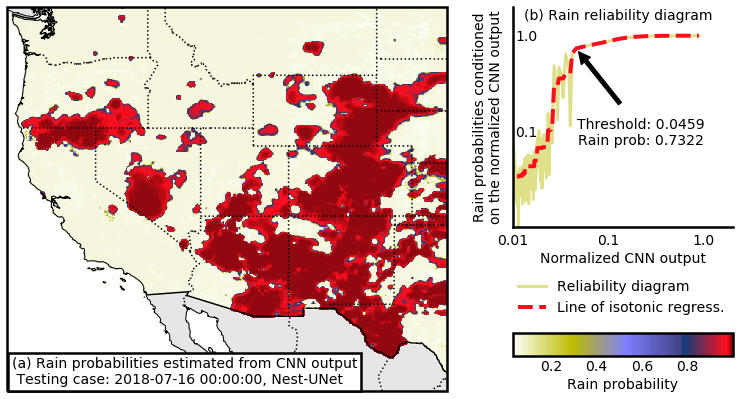

In [29]:
edge = [lon.min(), lon.max(), lat.min()+3, lat.max()-0.5]

fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2.15, 1], width_ratios=[2, 1])
ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[0, 1])

# ===== Macros ===== #

case_ind = 181+15 # the time index for this "example plot"
pick_ind = 377 # the index of the rain/no-rain thres

# Selecting XNET, JJA as the example
model_name = 'XNET_A_JJA'
model_name_short = 'XNET_A'

# load sklearn Isotonic Regression (IR) model 
#    warnings triggered for sklearn version mismatch
IR = load(IR_path.format(model_name))
temp_x = reliability_diagram[model_name][:, 1]
temp_y = IR.transform(temp_x) # predictions of IR

# ===== Pcolor background features ===== #

ax1.set_extent(edge , ccrs.Geodetic())
ax1.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
ax1.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=2)
ax1.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=2)
ax1.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=2)
ax1.outline_patch.set_linewidth(2.5)
# pcolor title
handle_text = ax1.text(0.01, 0.05, 
                       '(a) Rain probabilities estimated from CNN output\n Testing case: 2018-07-16 00:00:00, Nest-UNet', 
                       ha='left', va='center', fontsize=14, transform=ax1.transAxes)
handle_text.set_bbox(dict(facecolor='w', alpha=1, edgecolor='k', linewidth=2.5))

# ===== Line plot background features ===== #

ax2.set_aspect('equal', adjustable='box') # square axis
ax2 = gu.ax_decorate(ax2, True, True, True)
ax2.set_title('(b) Rain reliability diagram', fontsize=14, ha='left', va='top', y=0.965, x=0.05)

ax2.yaxis.grid(False)
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_ylim([1e-2, 2e0]); ax2.set_xlim([1e-2, 2e0])
ax2.set_yticks([1e-1, 1e0]); ax2.set_yticklabels([0.1, 1.0])
ax2.set_xticks([1e-2, 1e-1, 1e0]); ax2.set_xticklabels([0.01, 0.1, 1.0])
ax2.tick_params(axis="y", direction="in", pad=-25)
ax2.set_xlabel('Normalized CNN output', fontsize=14)
ax2.set_ylabel('Rain probabilities conditioned\non the normalized CNN output', fontsize=14)

# ===== Pcolor content

CS = ax1.pcolormesh(lon, lat, FLAG[model_name_short][case_ind, :, :], cmap=cmap_prob)

# ===== Line plot content ===== #

line_handle = []
line_handle += ax2.plot(temp_x, reliability_diagram[model_name][:, 0], 
                        lw=3.0, color=line_color1, label='Reliability diagram', zorder=1)
line_handle += ax2.plot(temp_x, temp_y, lw=4.0, ls='--', color=line_color2, label='Line of isotonic regress.')


# ===== Floating axis objects ===== #
# colorbar (bottom right)
ax_base = fig.add_axes([0.665, 0.17, 0.235, 0.1]) # 0.665
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='40%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Rain probability', fontsize=14)
tick_locator = ticker.MaxNLocator(nbins=5)
CBar.locator = tick_locator
CBar.update_ticks()
CBar.outline.set_linewidth(2.5)

# arrow and text
ax2.annotate(' ', xy=(temp_x[pick_ind], temp_y[pick_ind]), xytext=(temp_x[pick_ind]+0.1, temp_y[pick_ind]-0.6), fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.05))

ax2.text(temp_x[pick_ind]+0.175, temp_y[pick_ind]-0.66, 
         'Threshold: {}\nRain prob: {}'.format(np.round(temp_x[pick_ind], 4), np.round(temp_y[pick_ind], 4)), 
         ha='center', fontsize=14)

# legend
ax_lg = fig.add_axes([0.64, 0.285, 0.265, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=line_handle, loc=1, ncol=1, prop={'size':14}, fancybox=False);
LG.get_frame().set_facecolor('none')
LG.get_frame().set_edgecolor('none')
LG.get_frame().set_linewidth(0)

# Save figure
fig.savefig(fig_dir+'PCT_reliability_diagram.png', format='png', **fig_keys)

## Histogram 

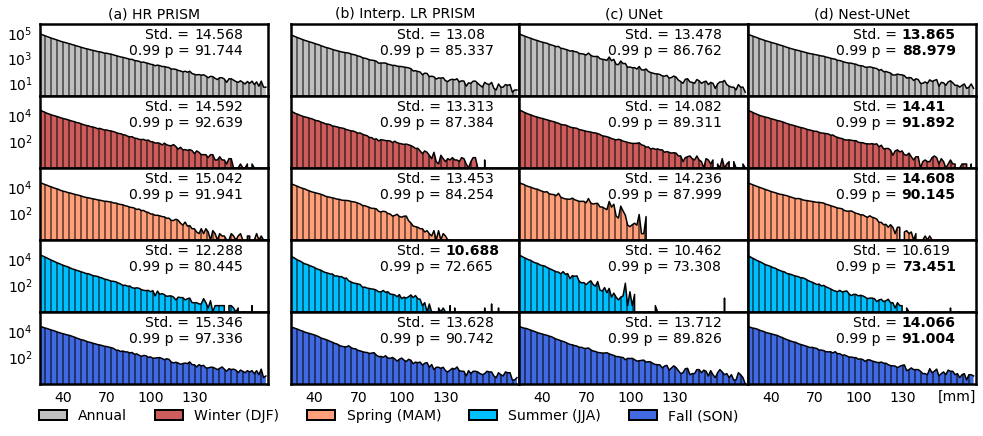

In [30]:
fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(5, 5, width_ratios=[1, 0.1, 1, 1, 1])

AX1 = []; AX2 = []; AX3 = []; AX4 = []; AX5 = []
for i in [0, 2, 3, 4]:
    AX1.append(plt.subplot(gs[0, i]))
    AX2.append(plt.subplot(gs[1, i]))
    AX3.append(plt.subplot(gs[2, i]))
    AX4.append(plt.subplot(gs[3, i]))
    AX5.append(plt.subplot(gs[4, i]))
AX = [AX1, AX2, AX3, AX4, AX5]

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# ===== Macros ===== #
# keys & title settings
PCT_keys_plot = ['PRISM_PCT', 'PCT_REGRID', 'UNET_A', 'XNET_A']    
titles  = ['(a) HR PRISM', '(b) Interp. LR PRISM', '(c) UNet', '(d) Nest-UNet']
ylabels = ['Annual', 'Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Fall (SON)']

# fonts
FW_std = [['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'bold', 'normal', 'normal'], 
          ['normal', 'normal', 'normal', 'bold']]

FW_99p = [['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold']]

# ===== Background features ===== #
YLIM = [5e5, 2.5e5, 2.5e5, 2.5e5, 2.5e5]
YTICKS = [[1e1, 1e3, 1e5], [1e2, 1e4], [1e2, 1e4], [1e2, 1e4], [1e2, 1e4]]

for i in range(5):
    for j in range(4):
        ax = AX[i][j]
        ax.set_yscale('log') # yaxis in log scale
        ax = gu.ax_decorate_box(ax)
        ax.set_xlim([pct_bins[0], pct_bins[-1]])
        ax.set_ylim([1, YLIM[i]])
    AX[i][0].tick_params(labelleft=True)
    AX[i][0].set_yticks(YTICKS[i])

for i in range(4):
    AX[-1][i].tick_params(labelbottom=True)
    AX[-1][i].set_xticks([40, 70, 100, 130])
    AX[0][i].set_title(titles[i], fontsize=14)
for i in range(5):
    AX[i][-1].yaxis.set_label_position("right")

AX[-1][-1].text(1, -0.225, '[mm]', fontsize=14, ha='right', transform=AX[-1][-1].transAxes)

# ===== Content ===== #

for i, sea in enumerate(['annual'] + seasons):
    for j, model in enumerate(PCT_keys_plot):
        AX[i][j].fill_between(pct_bins[:-1], np.zeros([99]), HIST['{}_{}'.format(model, sea)], 
                              facecolor=hist_colors[i], hatch='||')
        AX[i][j].plot(pct_bins[:-1], HIST['{}_{}'.format(model, sea)], 'k-', lw=1.5)
        
        
        param = np.round(HIST['{}_{}_param'.format(model, sea)], 3)
        AX[i][j].text(0.675, 0.95, 'Std. = \n0.99 p = '.format(param[0]),
                     ha='right', va='top', fontsize=14, transform=AX[i][j].transAxes)
        
        AX[i][j].text(0.675, 0.95, '{}'.format(param[0]),
                     ha='left', va='top', fontsize=14, fontweight=FW_std[i][j], transform=AX[i][j].transAxes)
        AX[i][j].text(0.675, 0.725, '{}'.format(param[1]),
                     ha='left', va='top', fontsize=14, fontweight=FW_99p[i][j], transform=AX[i][j].transAxes)
# ===== Floating axis objects ===== #

legend_box = []
for i in range(5):
    legend_box.append(patches.Patch(facecolor=hist_colors[i], edgecolor='k', linewidth=2.0, label=ylabels[i]))

ax_lg = fig.add_axes([0.03, -0.085, 0.73, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=5, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# Save
fig.savefig(fig_dir+'PCT_distrib_verif.png', format='png', **fig_keys)

## MAEs

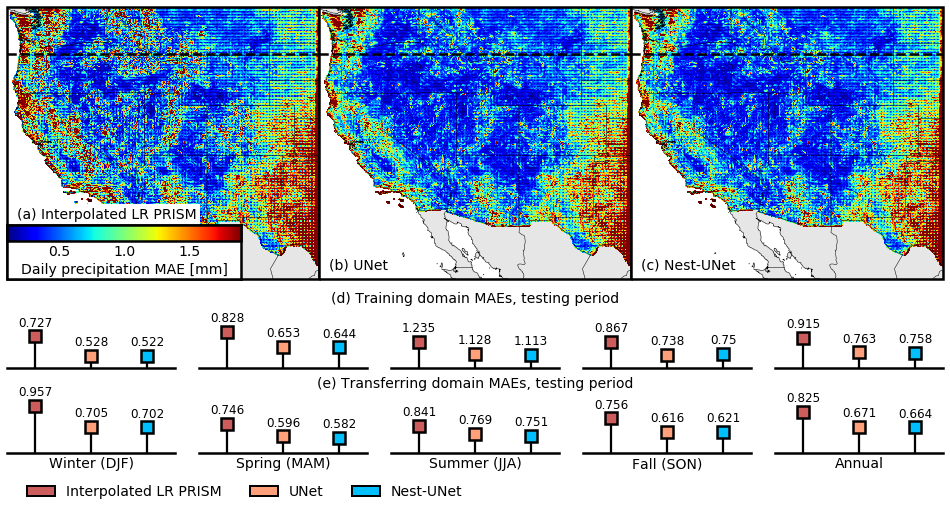

In [30]:
edge = [lon.min(), lon.max(), lat.min()+3, lat.max()-0.5]

fig = plt.figure(figsize=(13, 6.25)) #8

gs = gridspec.GridSpec(5, 39, height_ratios=[1.65, 0.1, 0.4, 0.1, 0.4])
ax_a1 = plt.subplot(gs[0,  0:13], projection=ccrs.PlateCarree()) 
ax_a2 = plt.subplot(gs[0, 13:26], projection=ccrs.PlateCarree())
ax_a3 = plt.subplot(gs[0, 26:39], projection=ccrs.PlateCarree()) 

ax_b1 = plt.subplot(gs[2, 0:7])
ax_b2 = plt.subplot(gs[2, 8:15])
ax_b3 = plt.subplot(gs[2, 16:23])
ax_b4 = plt.subplot(gs[2, 24:31])
ax_b5 = plt.subplot(gs[2, 32:39])

ax_c1 = plt.subplot(gs[4, 0:7])
ax_c2 = plt.subplot(gs[4, 8:15])
ax_c3 = plt.subplot(gs[4, 16:23])
ax_c4 = plt.subplot(gs[4, 24:31])
ax_c5 = plt.subplot(gs[4, 32:39])

ax_title1 = plt.subplot(gs[1, :])
ax_title2 = plt.subplot(gs[3, :])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX_map = [ax_a1, ax_a2, ax_a3]
AX_bar = [[ax_b1, ax_b2, ax_b3, ax_b4, ax_b5], 
          [ax_c1, ax_c2, ax_c3, ax_c4, ax_c5]]

# ===== Macros ===== #
bar_gap = 0.1
titles = ['(a) Interpolated LR PRISM', '(b) UNet', '(c) Nest-UNet']

# pcolor title position
Y = [0.210]+[0.025]*2

# line plot text position
base = [[0.4, 0.4, 1.0, 0.6, 0.6],
        [0.4, 0.4, 0.6, 0.4, 0.4]]
diff = [[0.7, 0.8, 0.6, 0.7, 0.7],
        [0.8, 0.8, 0.6, 0.7, 0.7]]
# line plot xlabel
xlabels = ['Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Fall (SON)', 'Annual']

# ===== Pcolor background features ===== #

for i, ax in enumerate(AX_map):
    ax.set_extent(edge, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=0.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
    ax.outline_patch.set_linewidth(2.5)
    ax.hlines(lat[504, 0], xmin=edge[0], xmax=edge[1], color='k', linestyle='--', lw=2.5)
    handle_box = ax.text(0.03, Y[i], titles[i], va='bottom', fontsize=14, transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='w', alpha=1, edgecolor='none'))

# ===== Line plot background features ===== #

# line plot titles
ax_title1.text(0.5, 0.5, '(d) Training domain MAEs, testing period',
               fontsize=14, ha='center', va='top', transform=ax_title1.transAxes)
ax_title1.set_axis_off()
ax_title2.text(0.5, 0.5, '(e) Transferring domain MAEs, testing period', 
               fontsize=14, ha='center', va='top', transform=ax_title2.transAxes)
ax_title2.set_axis_off()

# labels
for i in range(5):
    AX_bar[-1][i].spines["bottom"].set_visible(True)
    AX_bar[-1][i].set_xlabel(xlabels[i], fontsize=14)

# ===== Pcolor content ===== #

for i, ax in enumerate(AX_map):
    CS = ax.pcolormesh(lon, lat, MAE_PCT['{}_grid'.format(PCT_keys_pred[i])][...], vmin=0.1, vmax=1.9, cmap=plt.cm.jet)

# ===== Line plot content ===== #    

for n, domain in enumerate(domains):
    for i, sea in enumerate(seasons + ['annual']):
        ax = AX_bar[n][i]
        ax.set_ylim([base[n][i], base[n][i]+diff[n][i]])
        ax.set_xlim([-0.5*bar_gap, 2.5*bar_gap])
        ax = gu.ax_decorate(ax, False, False)
        ax.grid(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(False)
        for j, model in enumerate(PCT_keys_pred[:-1]):
            temp_val = np.array([MAE_PCT_season['{}_{}_{}'.format(model, domain, sea)]])
            marker_p, stem_p, base_p = ax.stem(np.array([0+bar_gap*j]), temp_val, use_line_collection=True)
            plt.setp(marker_p, marker='s', ms=12, mew=2.5, mec='k', mfc=hist_colors[1:][j], zorder=4)
            plt.setp(stem_p, linewidth=2.25, color='k')
            ax.text(np.array([0+bar_gap*j]), temp_val+0.2*diff[n][i], str(np.round(temp_val[0], 3)), 
                    va='center', ha='center', fontsize=12)

# ===== Floaing axis objects ===== #            
# colorbar
ax_base = fig.add_axes([0, 1-1.65/2.65+0.010, 0.25, 0.12])
[j.set_linewidth(2.5) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='30%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal',cax=cax) # ticks=[0.5, 1.0, 1.5], 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Daily precipitation MAE [mm]', fontsize=14)
CBar.outline.set_linewidth(2.5)
# legend
legend  = ['Interpolated LR PRISM', 'UNet', 'Nest-UNet']
legend_box = []
for i in range(3):
    legend_box.append(patches.Patch(facecolor=hist_colors[1:][i], edgecolor='k', linewidth=2.0, label=legend[i]))
ax_lg = fig.add_axes([0, -0.115, 0.5, 0.0725]) #0.385
ax_lg.set_axis_off()
[j.set_linewidth(2.5) for j in ax_lg.spines.values()]
ax_lg.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                  labelleft=False, labeltop=False, labelright=False, labelbottom=False)
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=3, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# Save
fig.savefig(fig_dir+'PCT_MAE_verif.png', format='png', **fig_keys)